# Angle Ply Laminate

---

This is an analysis of an *angle ply* ([-45, +45] degree) composite laminate plate.

In [1]:
import grama as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

X = gr.Intention()  # Use dfply symbolic notation

## Full DataFrame view
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

from grama.models import make_composite_plate_tension

md_plate = make_composite_plate_tension([-np.pi / 4, +np.pi / 4])

In [2]:
md_plate.printpretty()

model: Composite Plate in Tension m45-p45

  inputs:
    var_det:
    var_rand:
      E1_0: (+0) lognorm, {'loc': 1, 's': 0.02, 'scale': 114000000000.0}
      E2_0: (+0) lognorm, {'loc': 1, 's': 0.08, 'scale': 7000000000.0}
      nu12_0: (+0) norm, {'loc': 0.45, 'scale': 0.12727922061357855}
      G12_0: (+0) lognorm, {'loc': 1, 's': 0.1, 'scale': 4000000000.0}
      theta_0: (+0) uniform, {'loc': -0.8377580409572781, 'scale': 0.10471975511965977}
      t_0: (+0) uniform, {'loc': 0.00099, 'scale': 2e-05}
      sigma_11_t_0: (-1) lognorm, {'loc': 1, 's': 0.06, 'scale': 1400000000.0}
      sigma_22_t_0: (-1) lognorm, {'loc': 1, 's': 0.06, 'scale': 1400000.0}
      sigma_11_c_0: (-1) lognorm, {'loc': 1, 's': 0.06, 'scale': 500000000.0}
      sigma_22_c_0: (-1) lognorm, {'loc': 1, 's': 0.06, 'scale': 500000.0}
      sigma_12_s_0: (-1) lognorm, {'loc': 1, 's': 0.07, 'scale': 62000000.0}
      E1_1: (+0) lognorm, {'loc': 1, 's': 0.02, 'scale': 114000000000.0}
      E2_1: (+0) lognorm, {'loc'

This model has a large number of random variables, but no deterministic variables.

### Discrepancy Analysis

---

*Design allowables* analysis.

In [4]:
p = 0.01
df_qe = (
    md_plate
    >> gr.ev_conservative(quantiles=p)
    >> gr.tf_select(gr.starts_with("g_"))
    >> gr.tf_gather("limit", "g_da", gr.everything())
    >> gr.tf_arrange(X.g_da)
)
df_qe

limit        g_da
1      g_22_tension_0  -47.429961
6      g_22_tension_1  -47.429961
4        g_12_shear_0   -6.019180
9        g_12_shear_1   -6.019180
0      g_11_tension_0    0.441027
5      g_11_tension_1    0.441027
2  g_11_compression_0    2.565124
7  g_11_compression_1    2.565124
3  g_22_compression_0  136.603690
8  g_22_compression_1  136.603690

Monte carlo analysis

In [8]:
def qt(x):
    return gr.quant(x, p)  # Use global p


df_true = (
    md_plate
    >> gr.ev_monte_carlo(n=1e3, df_det="nom")
    >> gr.tf_summarize_each([qt], *md_plate.out)
    >> gr.tf_gather("limit", "g_true", gr.everything())
    >> gr.tf_mutate(limit=gr.str_replace(X.limit, "_qt", ""))
    >> gr.tf_arrange(X.g_true)
)
df_true

eval_monte_carlo() is rounding n...


limit     g_true
5      g_22_tension_1 -75.272313
0      g_22_tension_0 -74.993768
2        g_12_shear_0  -5.692754
1        g_12_shear_1  -5.522748
4      g_11_tension_0   0.467668
8      g_11_tension_1   0.469066
9  g_11_compression_0   1.781098
6  g_11_compression_1   1.788232
3  g_22_compression_0  19.457584
7  g_22_compression_1  21.254911

Join the two DataFrames and compute discrepancy.

In [9]:
df_discrepancy = (
    df_qe
    >> gr.tf_inner_join(df_true, by="limit")
    >> gr.tf_mutate(delta=X.g_true - X.g_da)
    >> gr.tf_arrange(X.delta)
)
df_discrepancy

limit        g_da     g_true       delta
8  g_22_compression_0  136.603690  19.457584 -117.146107
9  g_22_compression_1  136.603690  21.254911 -115.348779
1      g_22_tension_1  -47.429961 -75.272313  -27.842352
0      g_22_tension_0  -47.429961 -74.993768  -27.563807
6  g_11_compression_0    2.565124   1.781098   -0.784026
7  g_11_compression_1    2.565124   1.788232   -0.776892
4      g_11_tension_0    0.441027   0.467668    0.026641
5      g_11_tension_1    0.441027   0.469066    0.028038
2        g_12_shear_0   -6.019180  -5.692754    0.326426
3        g_12_shear_1   -6.019180  -5.522748    0.496432

For the angle ply, the compression limit states are the most anti-conservative to analyze with design allowables.

### Sweep Analysis

---

Let's generate sinew data to begin exploring this model.

In [13]:
df_sweeps = md_plate >> gr.ev_sinews(n_sweeps=10, n_density=40, df_det="nom")
df_sweeps >> gr.tf_describe()

t_0  sigma_22_t_1       nu12_0  sigma_11_t_0         G12_1  \
count  9200.000000  9.200000e+03  9200.000000  9.200000e+03  9.200000e+03   
mean      0.000998  1.384194e+06     0.428385  1.375964e+09  3.882702e+09   
std       0.000007  9.071032e+04     0.121588  9.440599e+07  3.564853e+08   
min       0.000990  1.000000e+00     0.092723  1.000000e+00  1.000000e+00   
25%       0.000991  1.316953e+06     0.387332  1.307032e+09  3.673751e+09   
50%       0.000996  1.357882e+06     0.450000  1.393440e+09  3.926565e+09   
75%       0.001007  1.402993e+06     0.505691  1.458808e+09  4.085408e+09   
max       0.001010  1.656811e+06     0.807277  1.656810e+09  5.296243e+09   

       sigma_12_s_1          E1_0          t_1  sigma_12_s_0  sigma_11_t_1  \
count  9.200000e+03  9.200000e+03  9200.000000  9.200000e+03  9.200000e+03   
mean   6.329394e+07  1.142929e+11     0.001001  6.327889e+07  1.400969e+09   
std    4.227848e+06  4.384887e+09     0.000005  5.697708e+06  8.320337e+07   
min    1.000000e+00  1.000000e+00     0.000990  1.000000e+00  1.000000e+00   
25%    6.196503e+07  1.126831e+11     0.000996  5.929651e+07  1.343889e+09   
50%    6.257161e+07  1.144270e+11     0.001000  6.200016e+07  1.364851e+09   
75%    6.443106e+07  1.157221e+11     0.001005  6.884228e+07  1.453456e+09   
max    7.546181e+07  1.205831e+11     0.001010  7.546181e+07  1.656810e+09   

        sigma_22_c_1          E1_1       nu12_1  sigma_11_c_0  sigma_11_c_1  \
count    9200.000000  9.200000e+03  9200.000000  9.200000e+03  9.200000e+03   
mean   491835.089609  1.124989e+11     0.463907  5.021121e+08  4.891444e+08   
std     27607.022186  4.216392e+09     0.119445  2.975324e+07  3.565610e+07   
min         1.000000  1.000000e+00     0.092723  1.000000e+00  1.000000e+00   
25%    473840.326719  1.112367e+11     0.354904  4.748873e+08  4.763481e+08   
50%    486588.774167  1.129448e+11     0.478120  5.101955e+08  4.842558e+08   
75%    505916.586188  1.135167e+11     0.574079  5.165861e+08  4.966972e+08   
max    591718.973066  1.205831e+11     0.807277  5.917180e+08  5.917180e+08   

           theta_1         G12_0   sigma_22_c_0          E2_1      theta_0  \
count  9200.000000  9.200000e+03    9200.000000  9.200000e+03  9200.000000   
mean      0.786257  4.024898e+09  503268.220225  6.898620e+09    -0.796974   
std       0.023909  5.247573e+08   33206.043219  5.892124e+08     0.026386   
min       0.733038  1.000000e+00       1.000000  1.000000e+00    -0.837758   
25%       0.768766  3.626089e+09  488369.957390  6.426892e+09    -0.818600   
50%       0.785398  3.753151e+09  500001.929786  6.918455e+09    -0.800152   
75%       0.802862  4.580789e+09  507480.793523  7.590026e+09    -0.773309   
max       0.837758  5.296243e+09  591718.973066  8.762426e+09    -0.733038   

               E2_0            Nx  sigma_22_t_0    sweep_ind  g_11_tension_0  \
count  9.200000e+03  9.200000e+03  9.200000e+03  9200.000000    9.200000e+03   
mean   6.915762e+09  1.258574e+06  1.406670e+06     4.500000   -6.178725e+05   
std    4.498769e+08  8.649787e+04  1.063295e+05     2.872437    1.883613e+07   
min    1.000000e+00  8.631559e+05  1.000000e+00     0.000000   -6.758096e+08   
25%    6.677376e+09  1.185339e+06  1.332343e+06     2.000000    5.545032e-01   
50%    6.923684e+09  1.278163e+06  1.397444e+06     4.500000    5.945935e-01   
75%    7.208806e+09  1.324942e+06  1.456358e+06     7.000000    6.123017e-01   
max    8.762426e+09  1.536844e+06  1.656811e+06     9.000000    1.000000e+00   

       g_22_tension_0  g_11_compression_0  g_22_compression_0  g_12_shear_0  \
count    9.200000e+03        9.200000e+03        9.200000e+03  9.200000e+03   
mean    -6.140113e+04        6.178752e+05        6.147548e+04 -3.514940e+05   
std      1.958559e+06        1.883613e+07        1.958557e+06  1.071734e+07   
min     -9.326694e+07        1.000000e+00        9.999978e-01 -3.774582e+08   
25%     -5.097703e+01        2.048986e+00        8.401552e+01 -4.866798e+00   
50%     

Observations:

- Among the limit states (outputs)
  + The longitudinal (11) `tension` states are largely non-critical (positive)
  + The transverse (22) `tension` states and `shear` states are frequently critical (negative)
  
Note however that a sinew design is not a Monte Carlo; the design above is not drawn from the distribution. We can't read these quantiles as reflective of the true output distributions.
  
We can see a lot more qualitative behavior by visualizing the sweeps.


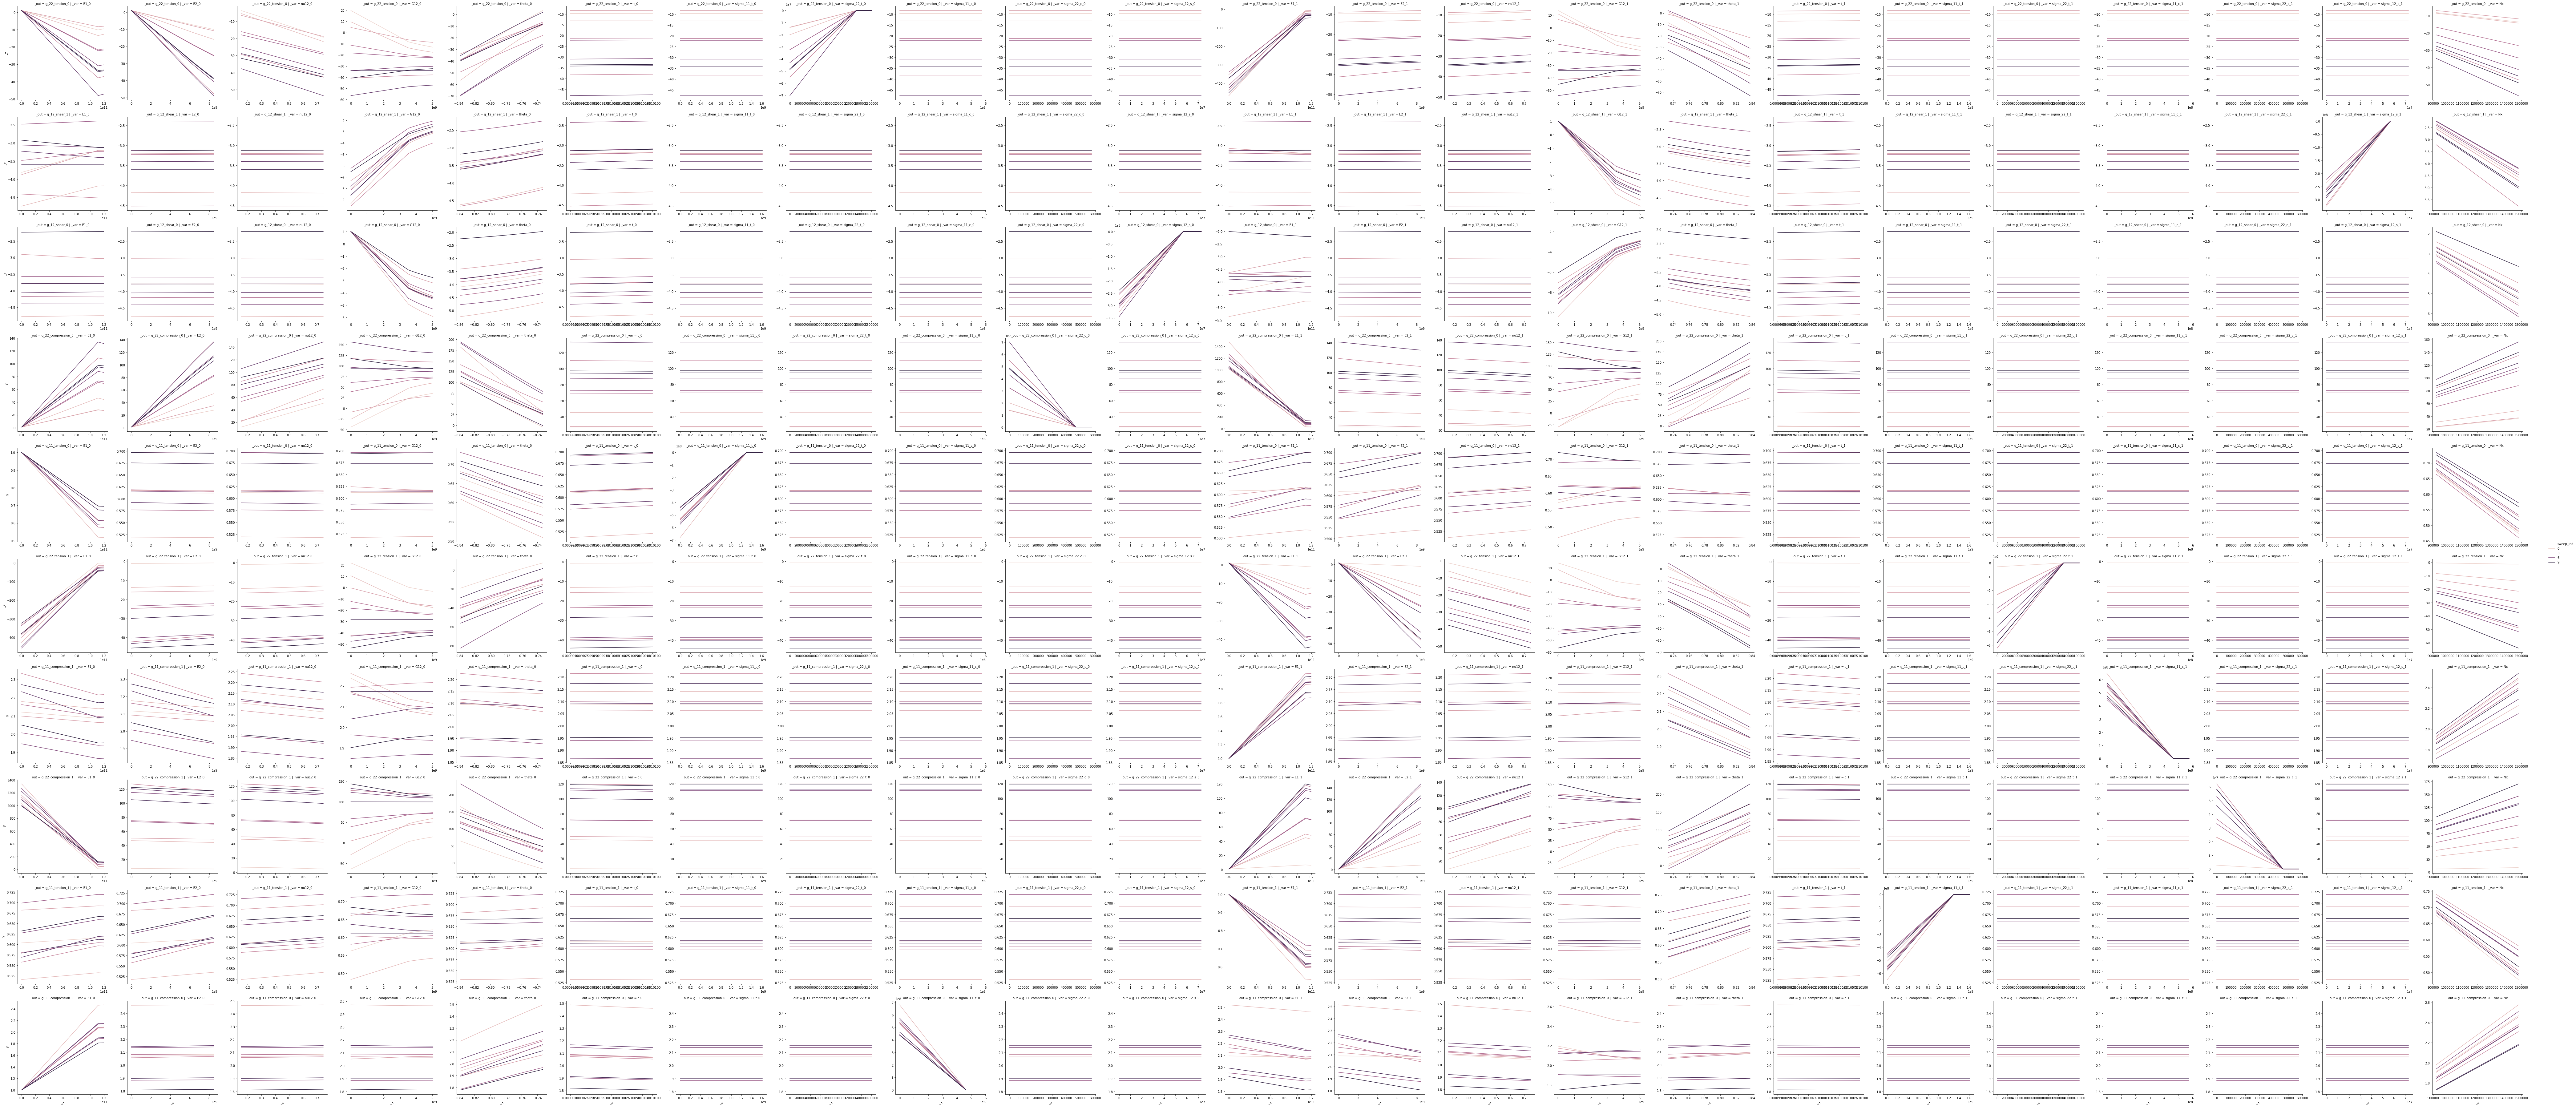

In [17]:
df_sweeps >> gr.pt_auto()
plt.savefig("./sweeps_full.png")

This full sinew plot is a bit overwhelming; I save a local copy for zooming. Observations:

- A number of the limit states are fairly nonlinear; it is difficult to tell which from the zoomed-out version.

Sinew plots can be useful for debugging a model during development; the following plot focuses on the limit states and critical stresses for a single ply. If the model is implemented correctly the effects should be *diagonal*, in the sense that each critical stress should only have an effect on its associated limit state. Furthermore, each effect should be linear with slope one.

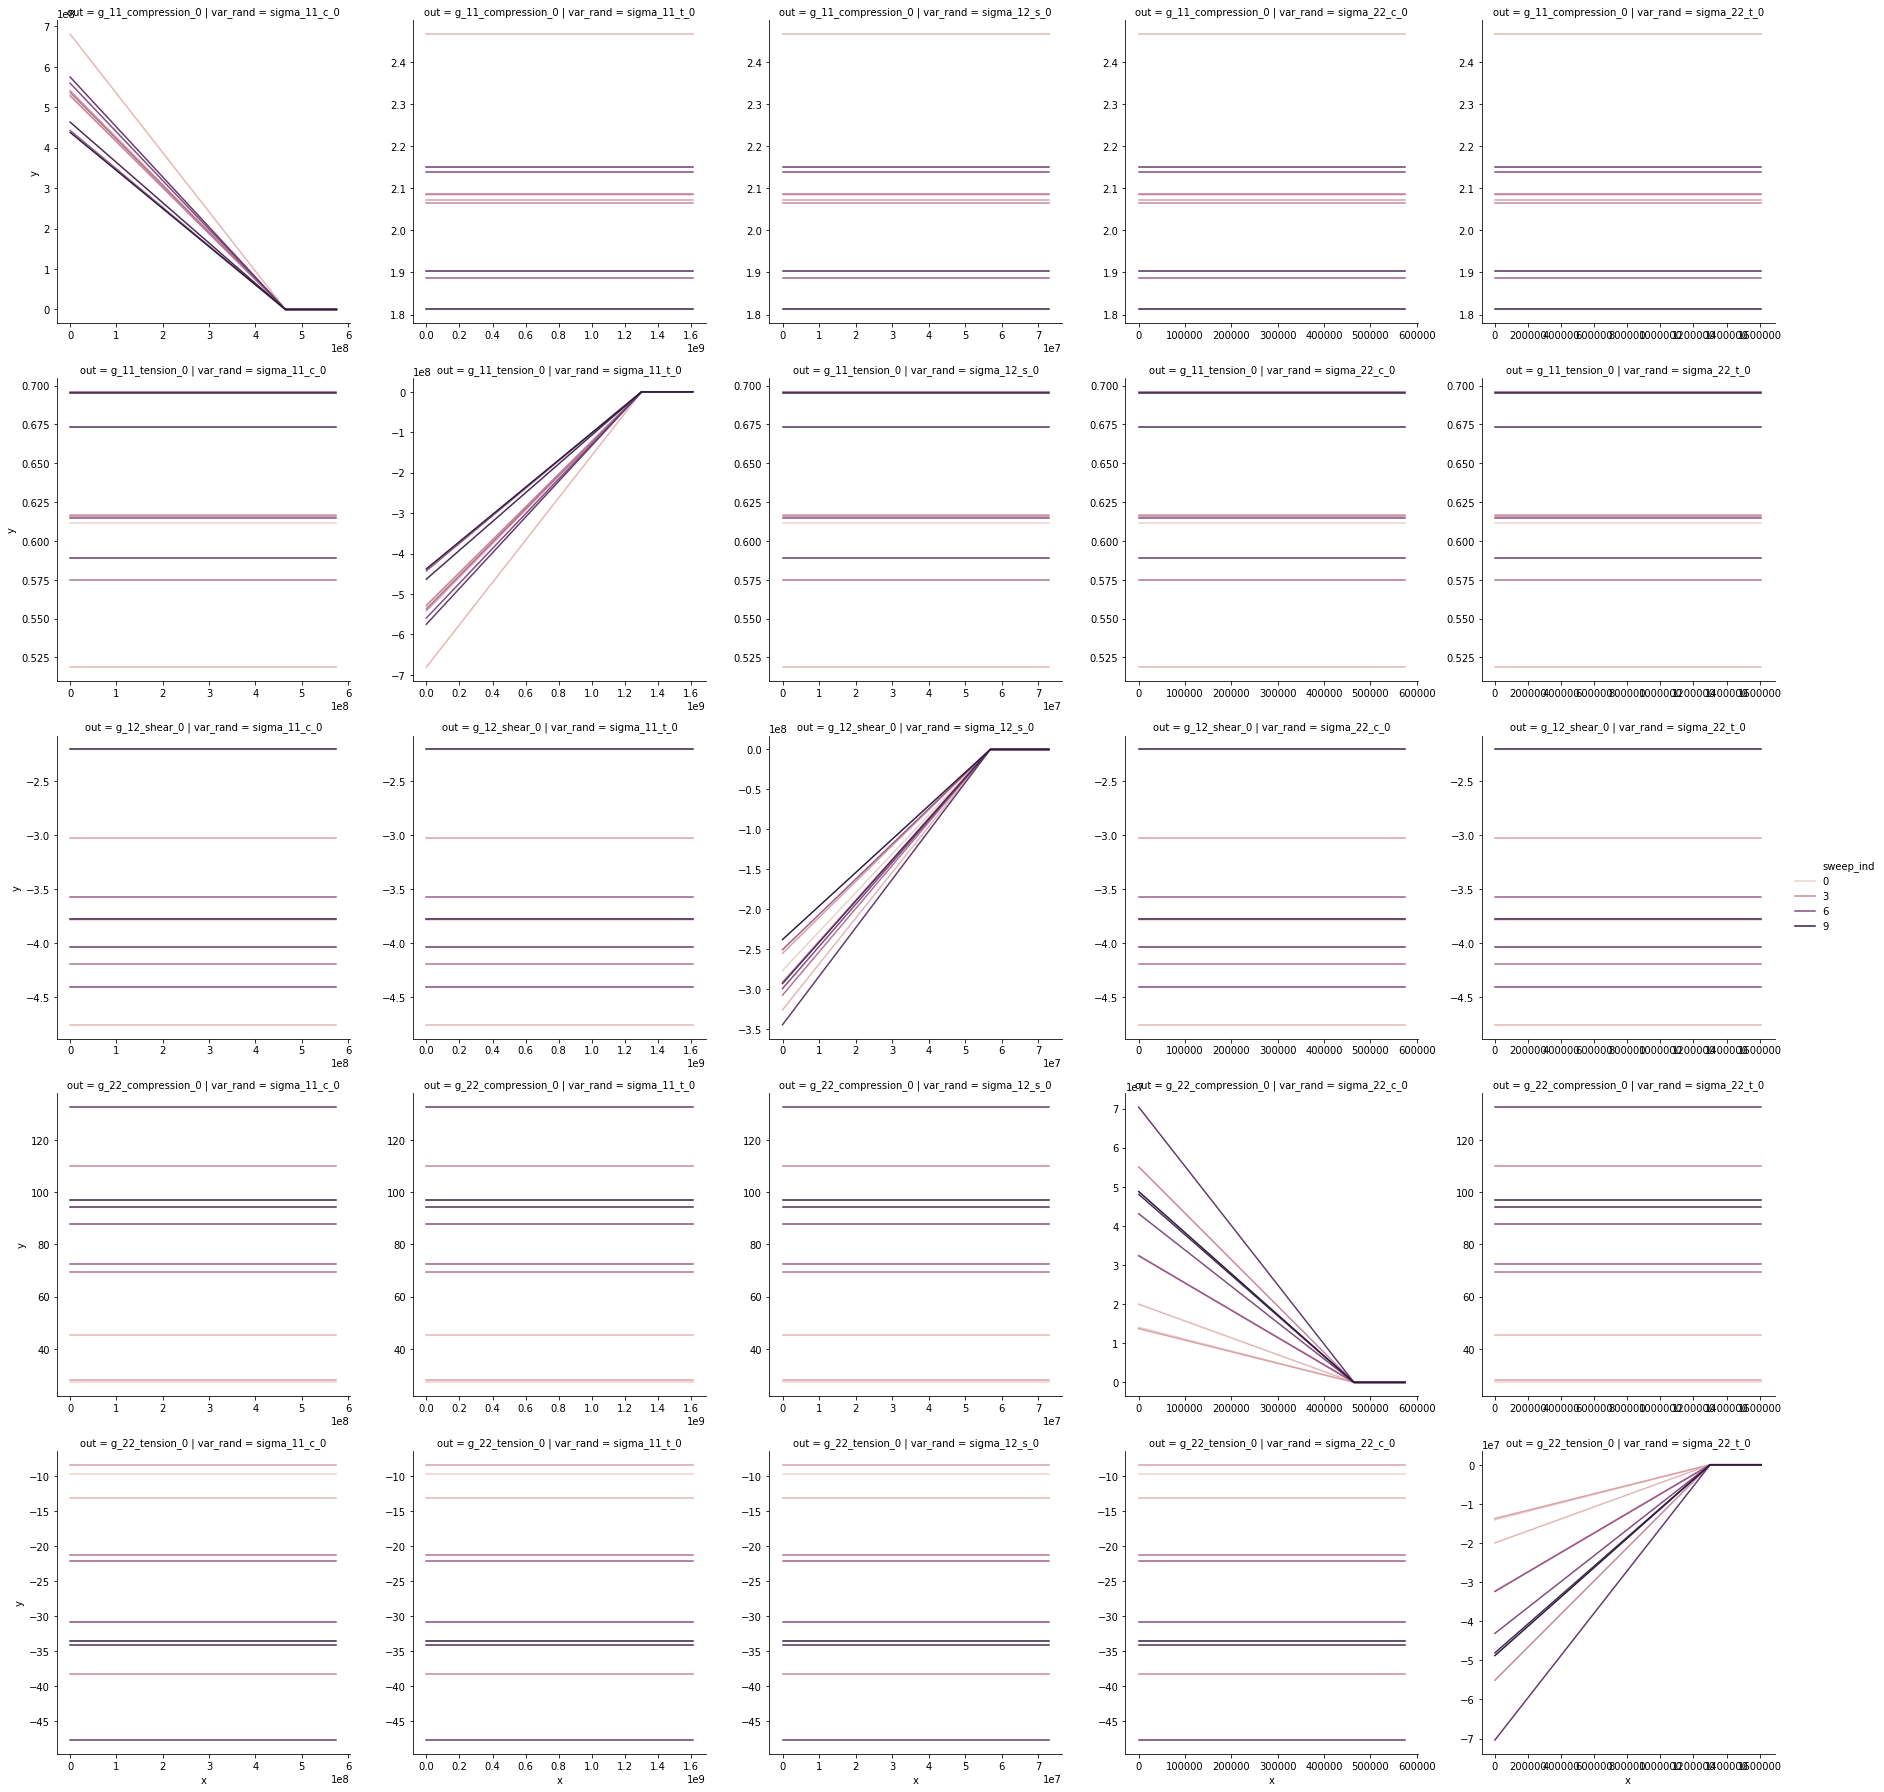

In [14]:
df_lam0 = (
    df_sweeps
    >> gr.tf_gather("var_rand", "x", md_plate.var_rand)
    >> gr.tf_gather("out", "y", md_plate.out)
    >> gr.tf_filter(
        gr.str_detect(X.var_rand, "sigma_\\w+_0")
        & gr.str_detect(X.out, "g_\\w+_0")
        & (X.var_rand == X.sweep_var)
    )
    >> gr.tf_arrange(X.var_rand, X.out)
)

sns.relplot(
    data=df_lam0,
    x="x",
    y="y",
    hue="sweep_ind",
    col="var_rand",
    row="out",
    kind="line",
    facet_kws=dict(sharex=False, sharey=False),
)

Here we can see the diagonal relationship, as expected.

From inspecting the full sinew plot, it appears the shear modulii `g_12_shear_i` have a strange cross-effect:

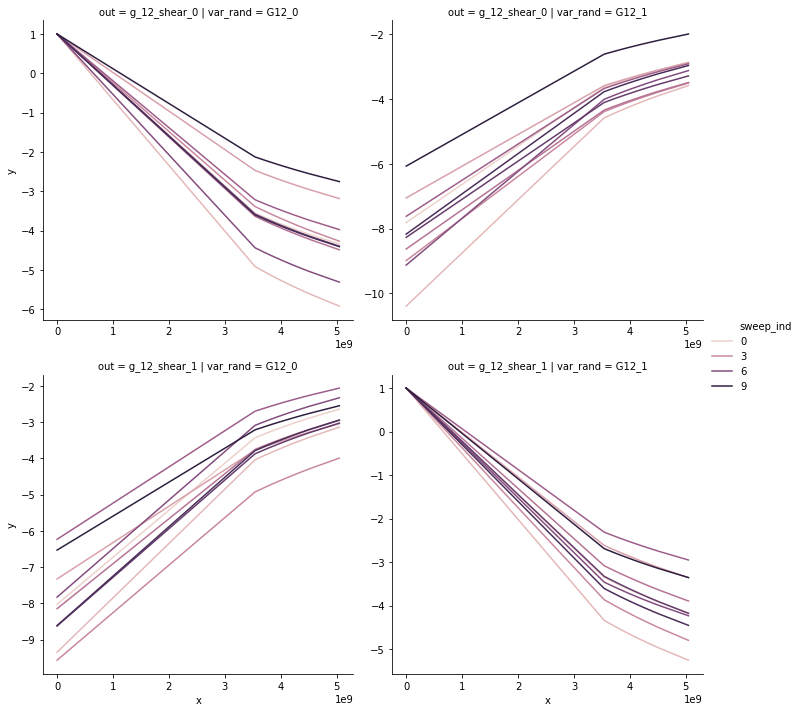

In [15]:
df_shear = (
    df_sweeps
    >> gr.tf_gather("var_rand", "x", md_plate.var_rand)
    >> gr.tf_gather("out", "y", md_plate.out)
    >> gr.tf_filter(
        gr.str_detect(X.var_rand, "G12_")
        & gr.str_detect(X.out, "g_12_shear")
        & (X.var_rand == X.sweep_var)
    )
    >> gr.tf_arrange(X.var_rand, X.out)
)

sns.relplot(
    data=df_shear,
    x="x",
    y="y",
    hue="sweep_ind",
    col="var_rand",
    row="out",
    kind="line",
    facet_kws=dict(sharex=False, sharey=False),
)

Observations:

- The shear modulus `g_12_shear_i` **decreases** the associated limit state `g_12_shear_i`
- The shear modulus `g_12_shear_i` **increases** the cross-associated limit state `g_12_shear_j`

Stiffening one ply causes that ply to take more of the total load, which reduces the load on the other ply. This explains the opposite effects observed above.

---

From close inspection of the full sinew plot, it appears the effect of certain variables switch across different sinews:

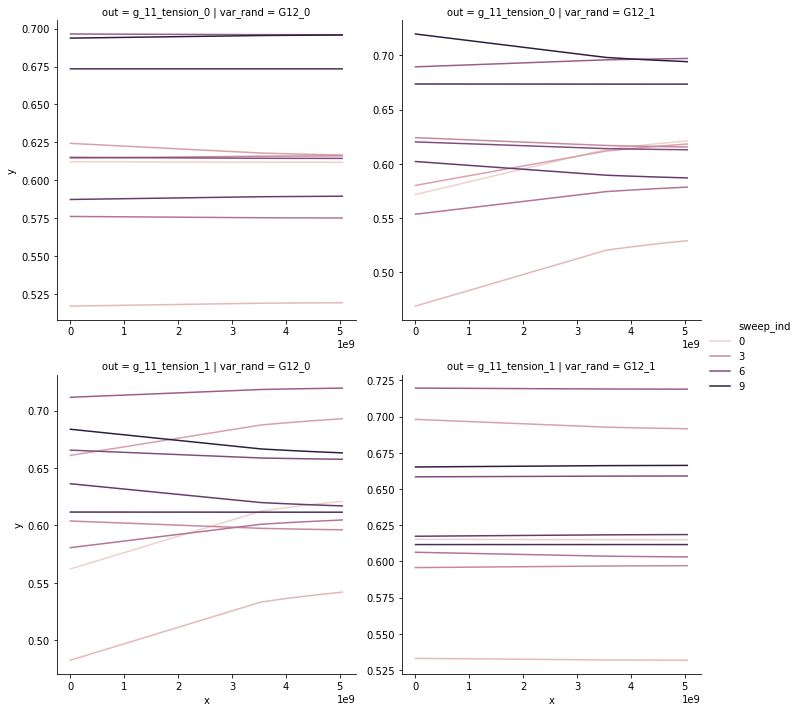

In [16]:
df_shear = (
    df_sweeps
    >> gr.tf_gather("var_rand", "x", md_plate.var_rand)
    >> gr.tf_gather("out", "y", md_plate.out)
    >> gr.tf_filter(
        gr.str_detect(X.var_rand, "G12_")
        & gr.str_detect(X.out, "g_11_tension")
        & (X.var_rand == X.sweep_var)
    )
    >> gr.tf_arrange(X.var_rand, X.out)
)

sns.relplot(
    data=df_shear,
    x="x",
    y="y",
    hue="sweep_ind",
    col="var_rand",
    row="out",
    kind="line",
    facet_kws=dict(sharex=False, sharey=False),
)

Here we can see the shear modulii `G12_i` have an effect on the opposite ply `tension` that can change in sign depending on the values of the other random variables. Thus the shear modulii have a **non-monotone** effect on the longitudinal tension limit state.

### Compressive states

The compressive states seem to be the most anti-conservative to analyze with allowables. Let's inspect the results to determine why.

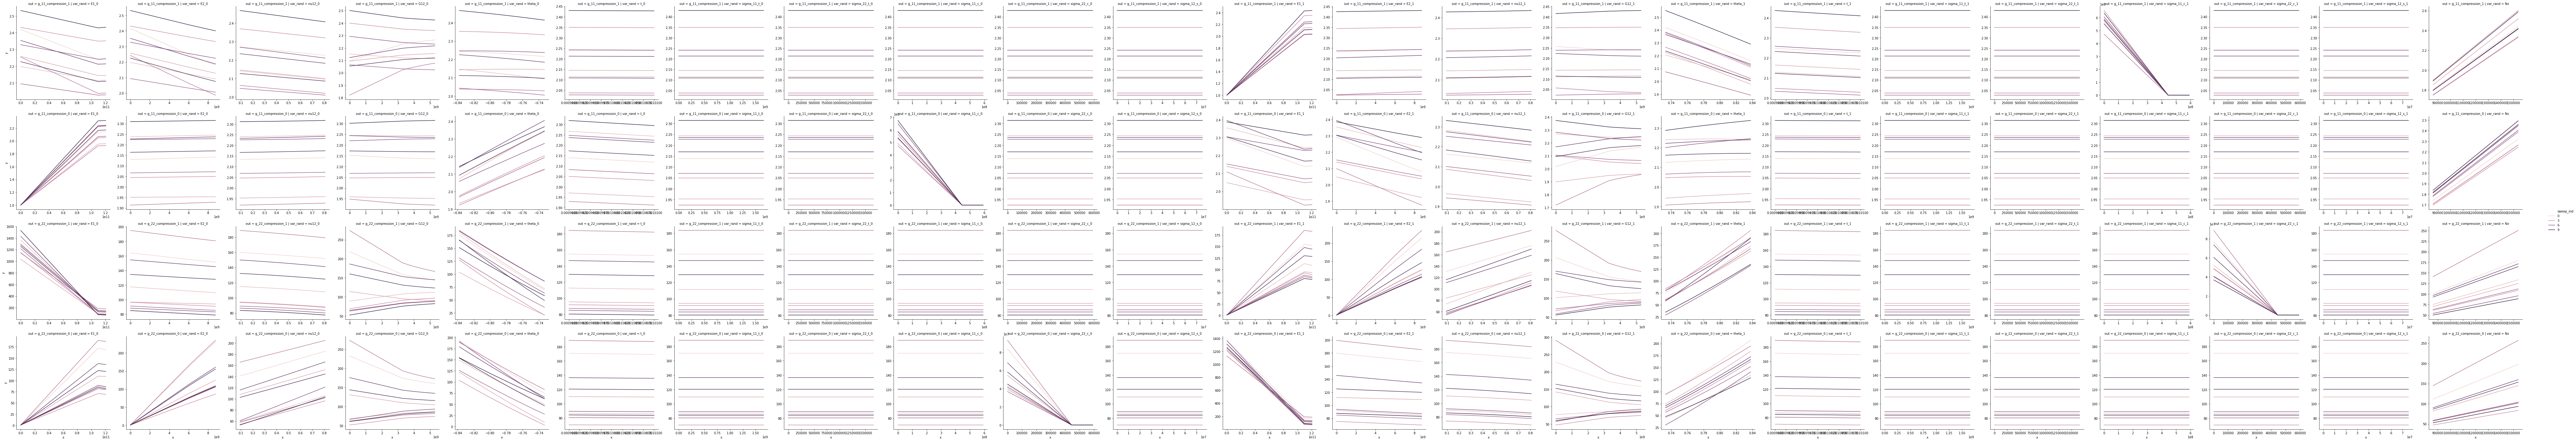

In [16]:
df_tmp = (
    df_sweeps
    >> gr.tf_gather("var_rand", "x", md_plate.var_rand)
    >> gr.tf_gather("out", "y", md_plate.out)
    >> gr.tf_filter(
        gr.str_detect(X.out, "compression") & (X.sweep_var == X.var_rand)
    )
)

sns.relplot(
    data=df_tmp,
    x="x",
    y="y",
    hue="sweep_ind",
    col="var_rand",
    row="out",
    kind="line",
    facet_kws=dict(sharex=False, sharey=False),
)